## Sparse Parametric Control Policies

In this tutorial, we utilize twin-delayed deep deterministic policy gradient (TD3) for learning a control policy for the pendulum. We compare the standard TD3 algorithm, utlizing neural networks for approximating value function and policy, with the sparse polynomial TD3 we developed. 

The sparse dictionary TD3 relies on dictionary learning and L$_0$ regularization to learn a sparse and interpreable policy. We implement three different types of library functions: (i) a polynomial libray, (ii) a Fourier library, and (iii) a polynomial and Fourier library. We adapt the code of pysindy  (https://github.com/dynamicslab/pysindy) for the implementation of the library function.

In [1]:
import gymnasium as gym
from utils.replay_buffer import ExperienceReplayBuffer
import torch
import numpy as np
from utils.agents.td3 import TD3
from utils.agents.sparse_dict_td3 import TD3 as sparse_dict_TD3

# Set seeds
seed = 23524
torch.manual_seed(seed)
np.random.seed(seed)

We start by defining environment, i.e., the Pendulum-v1 from OpenAIgym in this case, and the different versions of the TD3 algorithms. We introduce:
* the standard TD3 (line 20),
* the sparse dictionary TD3 with polynomial library (line 39), 
* the sparse dictionary TD3 with Fourier library (line 45), and
* the sparse dictionary TD3 with polynomial and Fourier library (line 52).

Similarly to the SINDy, the hyperparameters of the polynomial library are: the polynomial degree and the choice of using interaction terms (e.g., $x_0 * x_1^2$). The Fourier library  has the frequency as hyperparameters and includes $\sin(x)$ and $\cos(x)$. We extended the library to include interaction terms of the type $\sin(x_0)*\cos(x_1)$. Eventually, the polynomial and Fourier library simply combined the polynomial and Fourier libraries. 

In [ ]:
render = False

if render:
    env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
else:
    env = gym.make('Pendulum-v1', g=9.81)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set hyperparameters of the experiments
max_episodes = 250
max_steps = 200
warmup = 25

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_act = 2
buf_dim = int(max_episodes*max_steps)

training_buffer = ExperienceReplayBuffer(state_dim=obs_dim, action_dim=act_dim, max_size=int(1e6))

h_dim = 256
tau = 0.005
eval_interval = 20
batch_size = 256
training_start = 50
training_iteration = 100

# TD3 agent
agent = TD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, h_dim=h_dim, tau=tau, device=device)

scale = 1.0
droprate = 0.5

policy_type = 'polynomial' 
degree = 3
# polynomial TD3 agent
reg_coeff = 0.005
agent_poly = sparse_dict_TD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, policy_type=policy_type, degree_pi=degree, feature_scale=scale, reg_coeff=reg_coeff, droprate=droprate, tau=tau, device=device)

policy_type = 'fourier'
frequency = 1
# fourier TD3 agent
step_size = 0.01
agent_fourier = sparse_dict_TD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, policy_type=policy_type, degree_pi=degree, feature_scale=scale, reg_coeff=reg_coeff, droprate=droprate, tau=tau, frequency=frequency, device=device)

policy_type = 'polyfourier' 
frequency = 1
degree = 3
reg_coeff = 0.01
# polynomial-fourier TD3 agent
agent_polyfourier = sparse_dict_TD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, policy_type=policy_type, degree_pi=degree, feature_scale=scale, reg_coeff=reg_coeff, droprate=droprate, tau=tau, frequency=frequency, device=device)

Define train and evaluation functions.

In [3]:
def train_agent(agent, env, agent_type='td3'):
    training_rewards = []
    eval_rewards = []
    ep_reward = 0
    for episode in range(max_episodes):
        observation, info = env.reset()
        for steps in range(max_steps+1):
            if episode < warmup:
                action = env.action_space.sample()
            else:
                action = (agent.select_action(observation) + np.random.normal(0, max_act * 0.1, size=act_dim)).clip(-max_act, max_act)

            next_observation, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

            training_buffer.add(observation, action, next_observation, reward, done)

            observation = next_observation

            ep_reward += reward

            if done:
                print("Training episode {} is done with reward {}".format(episode, ep_reward))
                training_rewards.append(ep_reward)
                ep_reward = 0.
                done = False
                if episode > training_start:
                    agent.train(training_buffer, iterations=training_iteration, batch_size=batch_size)

                if episode % eval_interval == 0 and episode > 0:
                    eval_rew = eval_agent(agent, agent_type=agent_type, ep=episode)
                    eval_rewards.append(eval_rew)
                break

    env.close()

    eval_rew = eval_agent(agent, agent_type=agent_type, ep=max_episodes+1)
    eval_rewards.append(eval_rew)
    
    training_buffer.clear_memory()
    return training_rewards, eval_rewards

def eval_agent(agent, eval_episodes=10,agent_type='td3', ep=1):

    eval_env = gym.make('Pendulum-v1', g=9.81)
    avg_reward = 0.
    ep_reward = 0.
    for episode in range(eval_episodes):

        observation, info = eval_env.reset()

        for steps in range(max_steps + 1):

            action = agent.select_action(observation)

            next_observation, reward, terminated, truncated, info = eval_env.step(action)

            done = terminated or truncated

            observation = next_observation

            ep_reward += reward

            if done:
                print("Evaluation episode {} is done with reward {}".format(episode, ep_reward))
                avg_reward += ep_reward
                ep_reward = 0
                done = False
                break

    eval_env.close()

    avg_reward = avg_reward / eval_episodes
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")

    if agent_type == 'polytd3' or agent_type == 'fouriertd3' or agent_type == 'polyfouriertd3':
        agent.print_equations(ep=ep)

    return avg_reward

Train the TD3 agent.

In [ ]:
training_rewards_td3, eval_rewards_td3 = train_agent(agent, env, agent_type='td3')

Train the sparse dictionary TD3 with polynomial policy.

In [ ]:
training_rewards_polytd3, eval_rewards_polytd3 = train_agent(agent_poly, env, agent_type='polytd3')

Train the sparse dictionary TD3 with Fourier policy.

In [ ]:
training_rewards_fouriertd3, eval_rewards_fouriertd3 = train_agent(agent_fourier, env, agent_type='fouriertd3')

Train the sparse dictionary TD3 with polynomial and Fourier policy.

In [ ]:
training_rewards_polyfouriertd3, eval_rewards_polyfouriertd3 = train_agent(agent_polyfourier, env, agent_type='polyfouriertd3')

Plot the rewards over training of the different agents.

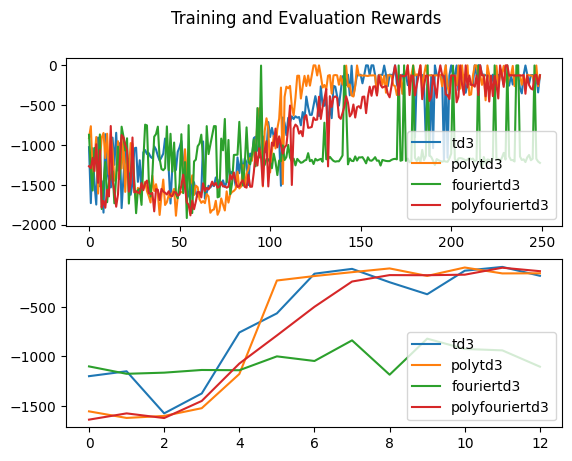

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('Training and Evaluation Rewards')

axs[0].plot(training_rewards_td3, label='td3')
axs[0].plot(training_rewards_polytd3, label='polytd3')
axs[0].plot(training_rewards_fouriertd3, label='fouriertd3')
axs[0].plot(training_rewards_polyfouriertd3, label='polyfouriertd3')
axs[0].legend(loc="lower right")

axs[1].plot(eval_rewards_td3, label='td3')
axs[1].plot(eval_rewards_polytd3, label='polytd3')
axs[1].plot(eval_rewards_fouriertd3, label='fouriertd3')
axs[1].plot(eval_rewards_polyfouriertd3, label='polyfouriertd3')
axs[1].legend(loc="lower right")

plt.savefig('figures/rewards.svg')